# Asset Allocation with Pytorch using Position Memory

 Goal of this notebook is to create a model to combine the signals from the various strategies to create an asset allocation neural network to outperform equally weighted, as Markowitz may not be appropriate as the signals may be to buy or sell the same asset therefore yielding a perfect correlation when active.

In [1]:
from loguru import logger
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
import shutil
import time
from tqdm import tqdm
import typing as t

import viz_neural_network as viz_nn

In [2]:
from quantified_strategies import loss, ml_utils, plot_utils, strategy_utils, utils

2024-02-27 17:25:57.399 | INFO     | quantified_strategies.ml_utils:get_device:26 - Running on the CPU


In [3]:
CASH = "CASH"

In [4]:
ASSETS = ["SPY", "QQQ", "TN=F", CASH]
ASSETS = ["SPY", "QQQ", CASH]
# ASSETS = ["XLC", "XLE", "XLF", "XLI", "XLK", "XLP", "XLRE", "XLU", "XLY", "XLV", CASH]
# ASSETS = ["XLK", CASH]
# ASSETS = ["SPY", "TN=F", CASH]
ASSETS

['SPY', 'QQQ', 'CASH']

In [5]:
LONG_OVERNIGHT_COSTS_DICT = {
    "SPY": 0.507559 / 508.3,
    "QQQ": 0.113025 / 437,
    "XLC": 0.020313 / 78.53,
    "XLE": 0.086145 / 86.25,
    "XLF": 0.040039 / 40.08,
    "XLI": 0.031045 / 120.00,
    "XLK": 0.053141 / 205.50,
    "XLP": 0.019255 / 74.47,
    "XLRE": 0.038212 / 38.28,
    "XLU": 0.015704 / 60.74,
    "XLY": 0.04701 / 181.00,
    "XLV": 0.038038 / 147.10,
}
SHORT_OVERNIGHT_COSTS_DICT = {
    "SPY": 0.127772 / 508.3,
    "QQQ": 0.089958 / 437,
    "XLC": 0.016167 / 78.53,
    "XLE": 0.021686 / 86.25,
    "XLF": 0.010079 / 40.08,
    "XLI": 0.024709 / 120.00,
    "XLK": 0.042296 / 205.50,
    "XLP": 0.015325 / 74.47,
    "XLRE": 0.009619 / 38.28,
    "XLU": 0.012499 / 60.74,
    "XLY": 0.037416 / 181.00,
    "XLV": 0.030275 / 147.10,
}

In [6]:
# Temporary Values
BORROWING_COSTS = [0 / 10_000 for _ in ASSETS]
FIXED_COSTS = [0 / 10_000 for _ in ASSETS]
FIXED_COSTS = [5 / 10_000 for asset in ASSETS if asset != CASH] + [0.0]
VAR_COSTS = [0 / 10_000 for _ in ASSETS]
VAR_COSTS = [5 / 10_000 for asset in ASSETS if asset != CASH] + [0.0]

LONG_OVERNIGHT_COSTS = [LONG_OVERNIGHT_COSTS_DICT.get(asset, 0.0) for asset in ASSETS]
SHORT_OVERNIGHT_COSTS = [SHORT_OVERNIGHT_COSTS_DICT.get(asset, 0.0) for asset in ASSETS]

In [7]:
[cost * 10_000 for cost in SHORT_OVERNIGHT_COSTS]

[2.5137123745819396, 2.0585354691075515, 0.0]

## Dataset Collection

In [8]:
def get_data(assets: str | t.List[str], is_classification: bool = True) -> t.Tuple[pd.DataFrame, pd.DataFrame]:

    def get_y() -> pd.DataFrame:
        price_data = [strategy_utils.get_data(ticker=ticker, columns="Adj Close").to_frame(name=ticker) for ticker in assets if ticker != "CASH"]
        price_data = pd.concat(price_data, axis=1)
        return_data = price_data.pct_change()
        if "CASH" in assets:
            return_data["CASH"] = 0.0
        return_data = return_data.shift(-1)
        return_data = return_data.dropna()

        if is_classification:
            return (return_data > 0).astype(int)
        
        return return_data

    def get_X() -> pd.DataFrame:
        strategy_returns = pd.read_csv(f"outputs/strategy_returns.csv", index_col=0, header=[0, 1, 2])
        strategy_returns = strategy_returns.loc[:, strategy_returns.columns.get_level_values(2).isin(assets)]
        strategy_returns.index = pd.DatetimeIndex(strategy_returns.index)
        is_active = ~(strategy_returns.isna())
        is_active = is_active.astype(int)
        return is_active

    assets = assets if isinstance(assets, list) else [assets]

    # Get target variables: these are the returns from entering a position from close to close t+1
    y = get_y()
    
    # Get explanatory variables: these are the signals from the strategies indicating whether to buy or not
    X = get_X()

    X = X.loc[X.index.isin(X.index.intersection(y.index))]
    y = y.loc[y.index.isin(y.index.intersection(X.index))]

    X = X.sort_index()
    y = y.sort_index()

    return X, y

orig_X_total, orig_y_total = get_data(assets=ASSETS, is_classification=False)

In [9]:
print(f"{orig_X_total.shape = }")
print(f"{orig_y_total.shape = }")

orig_X_total.shape = (6075, 16)
orig_y_total.shape = (6075, 3)


In [10]:
TRADE_ID = "trade_id"
STRATEGY_ID = "strategy_id"


def group_trades(X: pd.DataFrame, y: pd.DataFrame) -> t.Tuple[pd.DataFrame, pd.DataFrame]:
    
    new_X = X.copy()
    new_y = y.copy()
    
    # Fetch trade id i.e. change in strategy activation
    new_X[STRATEGY_ID] = new_X.apply(lambda x: sum([v * 10 ** i for i, v in enumerate(x.values)]), axis=1)
    new_X[TRADE_ID] = (new_X[STRATEGY_ID].diff().abs().fillna(1.0) > 0).cumsum()
    
    # Copy trade id to target/asset return dataframe
    new_y[TRADE_ID] = new_X[TRADE_ID]
    
    # Find trade id to first trade date
    trades = new_y.reset_index().set_index(TRADE_ID)["Date"]
    trades = trades[~trades.index.duplicated()]
    trades_to_date_dict = trades.to_dict()
    
    # Find return for each trade id
    new_y = new_y.groupby(by=TRADE_ID)[ASSETS].apply(lambda ret: strategy_utils.get_cumulative_return(returns=ret, total=True))
    new_y.index = new_y.index.map(trades_to_date_dict)
    new_y.index.name = "Date"

    X = X.loc[X.index.isin(new_y.index)].copy()

    # Calculate holding period before change
    # X["hold_days"] = (X.index[1:] - X.index[:-1]).days.tolist() + [0]
    # X = pd.concat([X, pd.DataFrame({"hold_days": (X.index[1:] - X.index[:-1]).days.tolist() + [1]}, index=X.index)], axis=1)
    
    # Add add last position columns
    X = pd.concat([X, pd.DataFrame(0, index=X.index, columns=[f"pos_{asset}" for asset in y.columns])], axis=1)

    return X, new_y

orig_X_total = pd.concat([
    orig_X_total, 
    pd.DataFrame(0, index=orig_X_total.index, columns=[f"pos_{asset}" for asset in orig_y_total.columns])
], axis=1)

# orig_X_total, orig_y_total = group_trades(X=orig_X_total, y=orig_y_total)

In [11]:
orig_X_total.head(5)

,"(event_trading, super_bowl, SPY)","(event_trading, super_bowl, QQQ)","(overnight_trading, short_term_reversal, SPY)","(overnight_trading, short_term_reversal, QQQ)","(seasonal_trading, buy_when_yields_are_low, SPY)","(seasonal_trading, buy_when_yields_are_low, QQQ)","(seasonal_trading, pay_day_strategy, SPY)","(seasonal_trading, pay_day_strategy, QQQ)","(seasonal_trading, santa_claus_strategy, SPY)","(seasonal_trading, santa_claus_strategy, QQQ)","(seasonal_trading, september_bear, SPY)","(seasonal_trading, september_bear, QQQ)","(seasonal_trading, tax_day_strategy, SPY)","(seasonal_trading, tax_day_strategy, QQQ)","(seasonal_trading, turn_around_tuesday_strategy, SPY)","(seasonal_trading, turn_around_tuesday_strategy, QQQ)",pos_SPY,pos_QQQ,pos_CASH
Date,,,,,,,,,,,,,,,,,,,
2000-01-03,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0
2000-01-04,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
2000-01-05,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
2000-01-06,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
2000-01-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
orig_X_total.columns

Index([                     ('event_trading', 'super_bowl', 'SPY'),
                            ('event_trading', 'super_bowl', 'QQQ'),
               ('overnight_trading', 'short_term_reversal', 'SPY'),
               ('overnight_trading', 'short_term_reversal', 'QQQ'),
            ('seasonal_trading', 'buy_when_yields_are_low', 'SPY'),
            ('seasonal_trading', 'buy_when_yields_are_low', 'QQQ'),
                   ('seasonal_trading', 'pay_day_strategy', 'SPY'),
                   ('seasonal_trading', 'pay_day_strategy', 'QQQ'),
               ('seasonal_trading', 'santa_claus_strategy', 'SPY'),
               ('seasonal_trading', 'santa_claus_strategy', 'QQQ'),
                     ('seasonal_trading', 'september_bear', 'SPY'),
                     ('seasonal_trading', 'september_bear', 'QQQ'),
                   ('seasonal_trading', 'tax_day_strategy', 'SPY'),
                   ('seasonal_trading', 'tax_day_strategy', 'QQQ'),
       ('seasonal_trading', 'turn_around_tuesday

In [13]:
orig_y_total.head(5)

,SPY,QQQ,CASH
Date,,,
2000-01-03,-0.039107,-0.068601,0.0
2000-01-04,0.001789,-0.025496,0.0
2000-01-05,-0.016071,-0.068678,0.0
2000-01-06,0.058077,0.123683,0.0
2000-01-07,0.003430,0.027778,0.0


In [14]:
assert orig_X_total.dropna().shape[0] == orig_X_total.shape[0]
assert orig_y_total.dropna().shape[0] == orig_y_total.shape[0]

In [15]:
assert len(orig_X_total.columns) == len(set(orig_X_total.columns))
assert len(orig_y_total.columns) == len(set(orig_y_total.columns))

## Create Pytorch Model

In [16]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

### Define `device` to use when training model

In [17]:
DEVICE = ml_utils.get_device()
DEVICE

2024-02-27 17:26:00.513 | INFO     | quantified_strategies.ml_utils:get_device:26 - Running on the CPU


device(type='cpu')

In [91]:

class Net(nn.Module):

    DEFAULT_LAYER_SIZES: t.List[int] = [8, 16, 8]
    DEFAULT_ALLOW_NEGATIVE_WEIGHTS: bool = False

    # Used when more than one asset is being traded, enables leverage.
    DEFAULT_MAX_WEIGHT: float = 1.0
    DEFAULT_MIN_WEIGHT: float = 0.0
    
    # Model Type: used to save model
    MODEL_TYPE: str = "rnn"

    # Sequences to use when creating prediction
    DEFAULT_SEQUENCE_LENGTH: int = 5
    # Step size to use when creating sequence
    DEFAULT_STEP_SIZE: int = 1
    
    def __init__(self, input_shape: int, output_shape: int, layer_sizes: t.List[int] = DEFAULT_LAYER_SIZES, 
                 sequence_length: int = DEFAULT_SEQUENCE_LENGTH, step_size: int = DEFAULT_STEP_SIZE,
                 allow_negative_weights: bool = DEFAULT_ALLOW_NEGATIVE_WEIGHTS, 
                 max_weight: float = None, min_weight: float = None):
        super().__init__()
        
        self.input_shape: int = input_shape
        self.output_shape: int = output_shape
        self.layer_sizes: t.List[int] = layer_sizes

        self.sequence_length: int = sequence_length
        self.step_size: int = step_size
        
        self.hidden_layers: int = 2
        self.hidden_size: int = layer_sizes[0]
        
        self.allow_negative_weights: bool = allow_negative_weights

        if (max_weight is None and min_weight is None) or self.output_shape == 1:
            max_weight = Net.DEFAULT_MAX_WEIGHT
            min_weight = Net.DEFAULT_MIN_WEIGHT
        elif max_weight is None and min_weight is not None:
            max_weight = -min_weight * (self.output_shape - 1) + 1
        elif max_weight is not None and min_weight is None:
            min_weight = -(max_weight - 1) / (self.output_shape - 1)
        else:
            pass

        # Assert MAX > MIN
        assert max_weight > min_weight, f"'max_weight' must be larger than 'min_weight': provided {max_weight = } and {min_weight = }"
        # Assert MAX + (n - 1) * MIN
        assert max_weight + (self.output_shape - 1) * min_weight == 1, f"'max_weight' plus (n - 1) * 'min_weight' should be equal to 1: " +\
            f"{max_weight} + {self.output_shape - 1} * {min_weight} = {max_weight + (self.output_shape - 1) * min_weight}"
        
        self.allow_negative_weights: bool = min_weight < 0
        self.max_weight: float = max_weight
        self.min_weight: float = min_weight
        self._max_weight: float = max_weight - 1 / self.output_shape
        self._min_weight: float = min_weight - 1 / self.output_shape

        last_shape = self.input_shape

        self.rnn = nn.RNN(
            input_size=self.input_shape, 
            hidden_size=self.hidden_size, 
            num_layers=self.hidden_layers, 
            batch_first=False,
        )
        last_shape = self.hidden_size
        
        for i, layer_size in enumerate(self.layer_sizes):
            setattr(self, f"fc{i}", nn.Linear(last_shape, layer_size))
            # setattr(self, f"dropout{i}", nn.Dropout(p=0.2))
            last_shape = layer_size
        self.fc_output = nn.Linear(last_shape, self.output_shape)
        # self.fc_output_1 = nn.Linear(last_shape, self.output_shape)
        # self.fc_output_2 = nn.Linear(2 * self.output_shape, self.output_shape)

    def forward(self, x):

        # Assuming x is (batch_size x seq_len x input_size)
        assert x.size(2) == self.input_shape, f"""Provided `x` is not of shape 
            batch_size x seq_len x input_size: expected ? x ? x {self.input_shape} but received {x.shape}"""
        seq_len = x.size(1)
        
        # Set initial hidden state: (hidden layers x sequence length x hidden size)
        h0 = torch.zeros(self.hidden_layers, seq_len, self.hidden_size)
        
        # Pass in x (sequence of values) and the initial hidden state (all zeros)
        # Do not need hidden output so discard
        x, _ = self.rnn(x, h0)
        
        # Output will be of shape batch_size x seq_len x hidden_size so get the last value in the sequence
        x = x[:, -1, :]
        
        # Previous positions in assets (Skip Connection: FROM)
        # x_pos = x[:, -self.output_shape:]

        for i, _ in enumerate(self.layer_sizes):
            x = getattr(self, f"fc{i}")(x)
            x = F.elu(x)
            # x = getattr(self, f"dropout{i}")(x)

        x = self.fc_output(x)
        
        if self.output_shape == 1:
            if self.allow_negative_weights:
                # Boundaries: (-1, +1)
                output = F.tanh(x)
            else:
                # Boundaries: (0, +1)
                output = F.sigmoid(x)
        else:
            # Boundaries: (min_weight, max_weight), Sum: 1.0
            output = F.softmax(x, dim=1)
            output = (self._max_weight - self._min_weight) * output + self._min_weight + 1 / self.output_shape

        return output

    @staticmethod
    def translate(X: torch.Tensor, y: torch.Tensor, sequence_length: int = DEFAULT_SEQUENCE_LENGTH, step_size: int = DEFAULT_STEP_SIZE,
                 ) -> t.Tuple[torch.Tensor, torch.Tensor]:
        
        num_samples: int = X.shape[0]
        num_variables: int = X.shape[1]
        
        # Create a new dataset with overlapping sequences
        new_X = []
        new_y = []
        for i in range(sequence_length, num_samples, step_size):
            # Fetch last `sequence_length` of X
            new_X.append(X[(i - sequence_length):i])
            # Fetch i-th value of y
            new_y.append(y[i])
    
        # Convert lists to tensors
        new_X = torch.stack(new_X)
        new_y = torch.stack(new_y)
            
        return new_X, new_y

    @staticmethod
    def load(input_shape: int, output_shape: int, name: str = "latest"):
        
        PATH = Path(os.getcwd())
        model_dict = torch.load(PATH / f"outputs/models/{Net.MODEL_TYPE}-model-{name}-state.dict")
        
        net = Net(input_shape=input_shape, output_shape=output_shape)
        net.load_state_dict(model_dict)
        net.eval()
        
        return net

    def save(self, name: str) -> None:
        PATH = Path(os.getcwd())
        torch.save(self.state_dict(), PATH / f"outputs/models/{self.MODEL_TYPE}-model-{name}-state.dict")
        shutil.copy(PATH / f"outputs/models/{self.MODEL_TYPE}-model-{name}-state.dict", 
                    PATH / f"outputs/models/{self.MODEL_TYPE}-model-latest-state.dict")
        return


def example():

    # Define input and output sizes for neural network
    INPUT_SHAPE = 10
    OUTPUT_SHAPE = 2
    print(f"Input Shape = {INPUT_SHAPE}, Output Shape = {OUTPUT_SHAPE}")

    # Generate example data
    N_SAMPLES = 10
    X_sample = torch.randn(N_SAMPLES, INPUT_SHAPE)
    y_sample = torch.randn(N_SAMPLES, 1)
    print(f"{X_sample.shape = }, {y_sample.shape = }")
    
    X_sample_translated, y_sample_translated = Net.translate(X=X_sample, y=y_sample)
    print(f"{X_sample_translated.shape = }, {y_sample_translated.shape = }")

    X_sample_translated = X_sample_translated.to(device=DEVICE)
    y_sample_translated = y_sample_translated.to(device=DEVICE)

    # Initiate Network
    my_net = Net(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, layer_sizes=[5, 10, 5], allow_negative_weights=False).to(device=DEVICE)
    output = my_net.forward(x=X_sample_translated)
    print(f"{output.shape = }")
    print(f"{output = }")

    my_net = Net(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, layer_sizes=[8, 16, 8], allow_negative_weights=True).to(device=DEVICE)
    output = my_net.forward(x=X_sample_translated)
    print(f"{output.shape = }")
    print(f"{output = }")

    my_net = Net(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, layer_sizes=[8, 16, 8], 
                 allow_negative_weights=True, max_weight=2.0, min_weight=-1.0).to(device=DEVICE)
    output = my_net.forward(x=X_sample_translated)
    print(f"{output.shape = }")
    print(f"{output = }")
    
    return

example()

Input Shape = 10, Output Shape = 2
X_sample.shape = torch.Size([10, 10]), y_sample.shape = torch.Size([10, 1])
X_sample_translated.shape = torch.Size([5, 5, 10]), y_sample_translated.shape = torch.Size([5, 1])
output.shape = torch.Size([5, 2])
output = tensor([[0.5124, 0.4876],
        [0.5110, 0.4890],
        [0.5120, 0.4880],
        [0.5121, 0.4879],
        [0.5102, 0.4898]], grad_fn=<AddBackward0>)
output.shape = torch.Size([5, 2])
output = tensor([[0.3757, 0.6243],
        [0.3817, 0.6183],
        [0.3688, 0.6312],
        [0.3781, 0.6219],
        [0.3787, 0.6213]], grad_fn=<AddBackward0>)
output.shape = torch.Size([5, 2])
output = tensor([[0.2908, 0.7092],
        [0.3159, 0.6841],
        [0.3042, 0.6958],
        [0.2837, 0.7163],
        [0.2999, 0.7001]], grad_fn=<AddBackward0>)


In [92]:
INPUT_SHAPE = 10
OUTPUT_SHAPE = 3
my_net = Net(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, layer_sizes=[5, 10, 5, 4], allow_negative_weights=False).to(device=DEVICE)
my_net

Net(
  (rnn): RNN(10, 5, num_layers=2)
  (fc0): Linear(in_features=5, out_features=5, bias=True)
  (fc1): Linear(in_features=5, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=4, bias=True)
  (fc_output): Linear(in_features=4, out_features=3, bias=True)
)

In [93]:
def update_datasets(net: Net, X_train: pd.DataFrame, y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame
                   ) -> t.Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:

    def update_dataset(X: pd.DataFrame, y: pd.DataFrame) -> t.Tuple[torch.Tensor, torch.Tensor]:

        # Get positions from network
        X_tensor, y_tensor = ml_utils.convert_data_to_tensors(X=X, y=y)
        X_tensor, y_tensor = Net.translate(X=X_tensor, y=y_tensor)
        
        y_pred_tensor = net(X_tensor)
        
        y_pred = pd.DataFrame(y_pred_tensor.detach().numpy(), index=X.index[X_tensor.shape[1]:], columns=[f"pos_{asset}" for asset in y.columns])
        y_pred = y_pred.reindex(index=X.index, fill_value=0.0)
        
        # Combine data
        new_X = pd.concat([X.iloc[:, :-y.shape[1]], y_pred.shift(1).fillna(0.0)], axis=1).fillna(0.0)
        # Convert dataset
        X, y = ml_utils.convert_data_to_tensors(X=new_X, y=y)
        X, y = Net.translate(X=X, y=y)

        assert X.shape[-1] == net.input_shape
        assert y.shape[-1] == net.output_shape

        return X, y

    net.eval()
    X_train_tensor, y_train_tensor = update_dataset(X=X_train, y=y_train)
    X_test_tensor, y_test_tensor = update_dataset(X=X_test, y=y_test)

    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor

OUTPUT_SHAPE = orig_y_total.shape[1]
INPUT_SHAPE = orig_X_total.shape[1]

my_net = Net(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, allow_negative_weights=False).to(device=DEVICE)
X_train, X_test, y_train, y_test = ml_utils.split_data(X=orig_X_total.copy(), y=orig_y_total.copy())
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = update_datasets(net=my_net, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

In [21]:
from loguru import logger
import numpy as np
import os
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
import time
import torch
from torch import nn
from torch import optim
from tqdm import tqdm
import typing as t

BATCH_SIZE: int = 64
DEVICE: torch.device = ml_utils.get_device()
EARLY_STOPPING_PATIENCE: int = 10
EARLY_STOPPING_MIN_DELTA: float = 0.0
EARLY_STOPPING_MIN_PERIODS: int = 100 # 0
EPOCHS: int = 2_000
LEARNING_RATE: float = 0.001
PATH: Path = Path(os.getcwd()).parent
SHUFFLE: bool = False
TRAIN_SIZE: float = 0.7

def train(net: nn.Module, X: pd.DataFrame, y: pd.DataFrame,
          loss_fn, store: bool = False, lr: bool = LEARNING_RATE, batch_size: int = BATCH_SIZE, epochs: int = EPOCHS,
          maximize_loss: bool = False, verbose: bool = True, **loss_kwargs):

    optimizer = optim.Adam(net.parameters(), lr=lr, maximize=maximize_loss)
    early_stopping = ml_utils.EarlyStopping(
        patience=EARLY_STOPPING_PATIENCE, 
        min_delta=EARLY_STOPPING_MIN_DELTA, 
        maximize=maximize_loss,
        min_periods=EARLY_STOPPING_MIN_PERIODS,
    )
    
    MODEL_NAME: str = f"{int(time.time())}"

    if verbose:
        logger.info(f"Training: {MODEL_NAME!r}")

    X_train, X_test, y_train, y_test = ml_utils.split_data(X=X, y=y, train_size=TRAIN_SIZE, shuffle=False)

    with open(PATH / f"scripts/outputs/models/{net.MODEL_TYPE}-model-{MODEL_NAME}.log", "a") as log:

        for epoch in range(epochs):

            X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = update_datasets(
                net=net, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

            net.train()
            for i in tqdm(range(0, len(X_train_tensor), batch_size)):

                batch_X = X_train_tensor[i:(i + batch_size)].to(device=DEVICE)
                batch_y = y_train_tensor[i:(i + batch_size)].to(device=DEVICE)

                acc, loss = ml_utils.fwd_pass(net=net, loss_fn=loss_fn, X=batch_X, y=batch_y, 
                                              optimizer=optimizer, do_train=True,
                                              **loss_kwargs)

            net.eval()
            loss, hit_rate = ml_utils.evaluate(net=net, loss_fn=loss_fn, X=X_train_tensor, y=y_train_tensor)
            val_loss, val_hit_rate = ml_utils.evaluate(net=net, loss_fn=loss_fn, X=X_test_tensor, y=y_test_tensor)
            if store:
                log.write(f"{MODEL_NAME},{time.time():.3f},{epoch},{loss:.6f},{hit_rate:.6f},{val_loss:.6f},{val_hit_rate:.6f}\n")
            if verbose:
                logger.info(f"Epoch: {epoch} / {epochs}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}," +\
                            f"Hit Rate: {hit_rate:.2%}, Val Hit Rate: {val_hit_rate:.2%}")

            # early stopping
            early_stopping(loss)
            if early_stopping.early_stop:
                if verbose:
                    logger.info(f"Early Stopping reached @ {epoch = }! Best Loss: {early_stopping.best_loss}, Loss: {loss}," +\
                                f"Val Loss: {val_loss}, Hit Rate: {hit_rate:.2%}, Val Accuracy: {val_hit_rate:.2%}")
                break

    if store:
        net.save(name=MODEL_NAME)
        shutil.copy(PATH / f"scripts/outputs/models/{net.MODEL_TYPE}-model-{MODEL_NAME}.log", 
                    PATH / f"scripts/outputs/models/{net.MODEL_TYPE}-model-latest.log")
    else:
        os.remove(PATH / f"scripts/outputs/models/{net.MODEL_TYPE}-model-{MODEL_NAME}.log")

    return

2024-02-27 17:26:01.685 | INFO     | quantified_strategies.ml_utils:get_device:26 - Running on the CPU


### Global Model Training Parameters

In [22]:
def my_cagr_loss(weights: torch.Tensor, returns: torch.Tensor, **kwargs) -> torch.Tensor:


    port_return = weights * returns
    try:
        port_return = torch.sum(port_return, dim=1)
    except IndexError:
        pass

    long_overnight_costs = loss.calc_long_overnight_cost(weights=weights, long_costs=kwargs.get("long_costs"))
    short_overnight_costs = loss.calc_short_overnight_cost(weights=weights, short_costs=kwargs.get("short_costs"))
    overnight_costs = long_overnight_costs + short_overnight_costs
        
    port_return = port_return - overnight_costs
    total_return = torch.prod(port_return + 1) - 1
    
    initial_value = 1.0
    activity = weights.shape[0]
    
    cagr = ((total_return + initial_value) / initial_value) ** (1 / activity) - 1    
    cagr_bps = cagr * 10_000
    
    return cagr_bps


def calc_trading_costs(weights: torch.Tensor, rate: torch.Tensor = None, fixed_costs: t.List[float] = None, var_costs: t.List[float] = None) -> torch.Tensor:

    if fixed_costs is None:
        fixed_costs = [0.0 for _ in range(weights.shape[1])]
    if var_costs is None:
        var_costs = [0.0 for _ in range(weights.shape[1])]
    
    # TODO: incorporate length held
    # NOTE: Requires weights not to be shuffled!
    zeros = torch.zeros((1, weights.shape[1]))
    weights = torch.cat((weights, zeros), dim=0)
    
    weights_to = weights[1:]
    weights_from = weights[:-1]
    
    change_in_weights = weights_to - weights_from
    abs_change_in_weights = torch.abs(change_in_weights)
    has_weights_changed = nn.Threshold(threshold=1e-10, value=1.0)(abs_change_in_weights)

    var_cost = torch.mul(abs_change_in_weights, torch.Tensor(var_costs))
    assert var_cost.shape == abs_change_in_weights.shape

    fixed_cost = torch.mul(has_weights_changed, torch.Tensor(fixed_costs))
    assert fixed_cost.shape == has_weights_changed.shape
    
    trading_cost = var_cost + fixed_cost
    total_trading_cost = torch.sum(trading_cost, dim=1)

    if rate is None:
        return total_trading_cost

    total_trading_cost = torch.mul(total_trading_cost, rate)

    return total_trading_cost
    
    

In [23]:
LOSS_FUNCTION = my_cagr_loss

MAXIMIZE_LOSS = True

BATCH_SIZE = 64
EPOCHS = 2_000
TEST_BATCH_SIZE = 128
LEARNING_RATE = 0.0001

STORE = True

assert BATCH_SIZE <= X_train.shape[0]
assert TEST_BATCH_SIZE <= X_test.shape[0]

## Model Training

In [24]:
OUTPUT_SHAPE = orig_y_total.shape[1]
INPUT_SHAPE = orig_X_total.shape[1]

print(f"Input Shape: {INPUT_SHAPE}, Output Shape: {OUTPUT_SHAPE}")

Input Shape: 19, Output Shape: 3


In [25]:
ALLOW_NEGATIVE_WEIGHTS = False

MAX_LEVERAGE_WEIGHT = 1.5
MIN_LEVERAGE_WEIGHT = (MAX_LEVERAGE_WEIGHT - 1) / (OUTPUT_SHAPE - 1)

MAX_WEIGHT = MAX_LEVERAGE_WEIGHT if ALLOW_NEGATIVE_WEIGHTS else 1.0
MIN_WEIGHT = -MIN_LEVERAGE_WEIGHT if ALLOW_NEGATIVE_WEIGHTS else 0.0

# MAX_WEIGHT = 1.5
# MIN_WEIGHT = None

print(f"Max. Weight: {MAX_WEIGHT}, Min. Weight: {MIN_WEIGHT}")

Max. Weight: 1.0, Min. Weight: 0.0


In [26]:
my_net = Net(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, layer_sizes=[8, 16, 8], 
             allow_negative_weights=ALLOW_NEGATIVE_WEIGHTS, max_weight=MAX_WEIGHT, min_weight=MIN_WEIGHT).to(device=DEVICE)
my_net

Net(
  (rnn): RNN(19, 8, num_layers=2)
  (fc0): Linear(in_features=8, out_features=8, bias=True)
  (fc1): Linear(in_features=8, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc_output): Linear(in_features=8, out_features=3, bias=True)
)

In [27]:
print(f"Max. Weight: {my_net.max_weight}, Min. Weight: {my_net.min_weight}")

Max. Weight: 1.0, Min. Weight: 0.0


In [28]:
train(net=my_net, X=orig_X_total, y=orig_y_total, loss_fn=LOSS_FUNCTION, 
               lr=LEARNING_RATE, batch_size=BATCH_SIZE, epochs=EPOCHS, maximize_loss=MAXIMIZE_LOSS, store=STORE,
               long_costs=LONG_OVERNIGHT_COSTS, short_costs=SHORT_OVERNIGHT_COSTS,
              )

2024-02-27 17:26:03.796 | INFO     | __main__:train:40 - Training: '1709054763'
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:01<00:00, 41.05it/s]
2024-02-27 17:26:06.762 | INFO     | __main__:train:67 - Epoch: 0 / 2000, Loss: 1.0884, Val Loss: 4.1997,Hit Rate: 54.16%, Val Hit Rate: 56.66%
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:01<00:00, 49.66it/s]
2024-02-27 17:26:09.342 | INFO     | __main__:train:67 - Epoch: 1 / 2000, Loss: 1.0097, Val Loss: 4.0901,Hit Rate: 53.99%, Val Hit Rate: 56.33%
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:01<00:00, 49.70it/s]
2024-02-27 17:26:12.117 | INFO     | __main__:train:67 - Epoch: 2 / 2000, Loss: 0.8798, Val Loss: 3.8862,Hit Rate: 53.64%, Val Hit Rate: 56.49%
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:01<00:00, 44.55it/s]
2024-02-

In [29]:
X_train_df, X_test_df, y_train_df, y_test_df = ml_utils.split_data(X=orig_X_total.copy(), y=orig_y_total.copy(), train_size=TRAIN_SIZE, shuffle=False)
X_train, y_train, X_test, y_test = update_datasets(
    net=my_net, X_train=X_train_df, y_train=y_train_df, X_test=X_test_df, y_test=y_test_df)

## Visualise Neural Network

In [30]:
n_sample = 0
training_data = False

X_sample = X_train[n_sample] if training_data else X_test[n_sample]
y_sample = y_train[n_sample] if training_data else y_test[n_sample]

print(pd.Series(X_sample.detach().numpy(), index=orig_X_total.columns))

viz_nn.visualize_layer_activations(
    fig=plt.figure(figsize=(12, 12)), 
    network=my_net,
    X=X_sample.reshape(-1, orig_X_total.shape[1]),
    y=y_sample,
    X_labels=orig_X_total.columns.tolist(),
    y_labels=ASSETS,
    X_min=0.0, X_max=1.0,
    y_min=my_net.min_weight, y_max=my_net.max_weight,
)

ValueError: Length of values (5) does not match length of index (19)

## Plot Loss

C:\Users\tomw1\PycharmProjects\quantified_strategies\quantified_strategies\plot_utils.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(contents["epoch"].tolist()[::n])


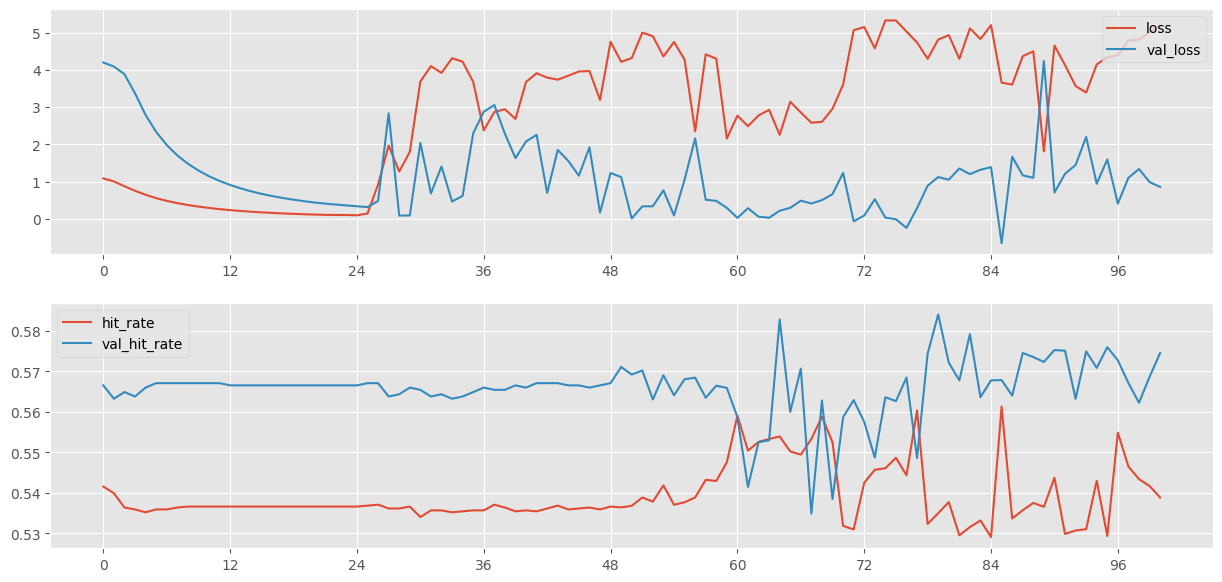

In [31]:
MODEL_NAME = f"{Net.MODEL_TYPE}-model-latest"
plot_utils.create_loss_graph(model_name=MODEL_NAME)

In [32]:
# raise ValueError

## Apply Asset Allocator

In [32]:
LOAD_MODEL = False

In [33]:
X_total_df, y_total_df = get_data(assets=ASSETS, is_classification=False)
X_train_df, X_test_df, y_train_df, y_test_df = ml_utils.split_data(X=X_total_df, y=y_total_df)
# X_train_df["hold_days"] = 0
# X_test_df["hold_days"] = 0

In [34]:
if LOAD_MODEL:
    model = Net.load(input_shape=X_total_df.shape[1], output_shape=y_total_df.shape[1], name="latest")
else:
    model = my_net
model

Net(
  (rnn): RNN(19, 8, num_layers=2)
  (fc0): Linear(in_features=8, out_features=8, bias=True)
  (fc1): Linear(in_features=8, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc_output): Linear(in_features=8, out_features=3, bias=True)
)

In [118]:
def run(X_df: pd.DataFrame, y_df: pd.DataFrame, is_train: bool = True, sub_cost: int = 1.0) -> pd.DataFrame:
    
    def get_allocation():
    
        def _get_allocation(index: t.Any, last_pos: pd.DataFrame, hold_days: int):

            x = pd.concat([
                X_df.loc[X_df.index <= index].tail(model.sequence_length+1), 
                last_pos.loc[last_pos.index <= index].tail(model.sequence_length+1),
            ], axis=1).fillna(0.0)
            
            x_tensor, y_tensor = ml_utils.convert_data_to_tensors(X=x, y=y_df)
            x_tensor, _ = model.translate(X=x_tensor, y=y_tensor)
            
            last_pos2 = pd.Series(model(x_tensor)[[-1]].reshape(-1).detach().numpy(), index=y_df.columns)
            return last_pos2, hold_days
        
        A = []
        last_position = pd.DataFrame(0, index=X_df.index[:(model.sequence_length+1)], columns=y_df.columns)
        hold_days = 0
        for i, index in enumerate(X_df.index[(model.sequence_length+1):]):
            
            last_pos, hold_days = _get_allocation(
                index=index, last_pos=last_position, hold_days=hold_days)
            
            A.append(last_pos.to_frame(name=index).T)
            last_position = pd.concat([last_position.loc[last_position.index != index], last_pos.to_frame(name=index).T], axis=0) 
        
        A = pd.concat(A, axis=0)
        
        return A

    long_costs_df = pd.Series(LONG_OVERNIGHT_COSTS, index=ASSETS)
    short_costs_df = pd.Series(SHORT_OVERNIGHT_COSTS, index=ASSETS)
    
    # Get Allocation
    alloc = get_allocation()
    benchmark_alloc = X_df.iloc[:, :-1].groupby(level=2, axis=1).sum()
    benchmark_alloc = benchmark_alloc.div(benchmark_alloc.sum(axis=1), axis=0).fillna(0.0)
    benchmark_alloc[CASH] = 1 - benchmark_alloc.sum(axis=1)
    hodl_alloc = pd.DataFrame(1 / (len(ASSETS) - 1), index=alloc.index, columns=ASSETS)
    hodl_alloc[CASH] = 0.0

    strat_overnight_long_costs = alloc.clip(lower=0.0).dot(long_costs_df)
    strat_overnight_short_costs = alloc.clip(upper=0.0).abs().dot(short_costs_df)
    costs = strat_overnight_long_costs + strat_overnight_short_costs

    # Get Strategy returns
    hodl_ret = (y_df * hodl_alloc).sum(axis=1) - sub_cost * (hodl_alloc.clip(lower=0.0).dot(long_costs_df) + hodl_alloc.clip(upper=0.0).abs().dot(short_costs_df))
    strat_bm_ret = (y_df * benchmark_alloc).sum(axis=1) - sub_cost * (benchmark_alloc.clip(lower=0.0).dot(long_costs_df) + benchmark_alloc.clip(upper=0.0).abs().dot(short_costs_df))
    strat_ret = (y_df * alloc).sum(axis=1).reindex(index=alloc.index)
    strat_ret_with_cost = strat_ret - costs
    
    strat_pos = alloc.loc[:, alloc.columns != CASH].sum(axis=1).round(3)
    strat_bm_pos = benchmark_alloc.loc[:, benchmark_alloc.columns != CASH].sum(axis=1).round(3)
    
    cum_hodl_ret = strategy_utils.get_cumulative_return(returns=hodl_ret, total=False)
    cum_strat_bm_ret = strategy_utils.get_cumulative_return(returns=strat_bm_ret, total=False)
    cum_strat_ret = strategy_utils.get_cumulative_return(returns=strat_ret, total=False)
    cum_strat_ret_with_cost = strategy_utils.get_cumulative_return(returns=strat_ret_with_cost, total=False)
    
    hodl_dd = strategy_utils.get_drawdown_statistics(returns=hodl_ret)["drawdown"]
    strat_bm_dd = strategy_utils.get_drawdown_statistics(returns=strat_bm_ret)["drawdown"]
    strat_dd = strategy_utils.get_drawdown_statistics(returns=strat_ret)["drawdown"]
    strat_with_costs_dd = strategy_utils.get_drawdown_statistics(returns=strat_ret)["drawdown"]
    
    prop_cycle = plt.rcParams["axes.prop_cycle"]
    colors = prop_cycle.by_key()["color"]
    color_map = {"strategy": colors[0], "hodl": colors[1], "strategy_bm": colors[2], "strategy_with_costs": colors[3]}
    
    fig, ax = plt.subplots(figsize=(15, 7))
    
    ax.plot(cum_hodl_ret, label="HODL", color=color_map["hodl"])
    ax.plot(cum_strat_ret, label="Strategy", color=color_map["strategy"])
    ax.plot(cum_strat_bm_ret, label="Strategy: BM", color=color_map["strategy_bm"])
    ax.plot(cum_strat_ret_with_cost, label="Strategy with Costs", color=color_map["strategy_with_costs"])
    ax.fill_between(
        cum_hodl_ret.index,
        0, cum_strat_ret - cum_hodl_ret,
        alpha=0.2, color="blue",
        label="Strategy - HODL",
    )
    ax.plot(hodl_dd, alpha=0.2, label="HODL: DD", color=color_map["hodl"])
    ax.plot(strat_dd, alpha=0.2, label="Strategy: DD", color=color_map["strategy"])
    ax.plot(strat_bm_dd, alpha=0.2, label="Strategy BM: DD", color=color_map["strategy_bm"])
    ax.plot(strat_with_costs_dd, alpha=0.2, label="Strategy with Costs: DD", color=color_map["strategy_with_costs"])
    
    if is_train:
        plt.title("Strategy: Training")
    else:
        plt.title("Strategy: Test")
    plt.legend(loc="upper left")
    plt.show()
    
    desc = pd.concat([
        strategy_utils.describe(returns=strat_ret, pos=strat_pos, daily=True).to_frame(name="strategy"),
        strategy_utils.describe(returns=strat_bm_ret, pos=strat_bm_pos, daily=True).to_frame(name="strategy(bm)"),
        strategy_utils.describe(returns=hodl_ret, daily=True).to_frame(name="hodl")
    ], axis=1)
        
    return desc, alloc


In [119]:
INCLUDE_COST = 0.0

C:\Users\tomw1\AppData\Local\Temp\ipykernel_15800\2399179029.py:38: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  benchmark_alloc = X_df.iloc[:, :-1].groupby(level=2, axis=1).sum()


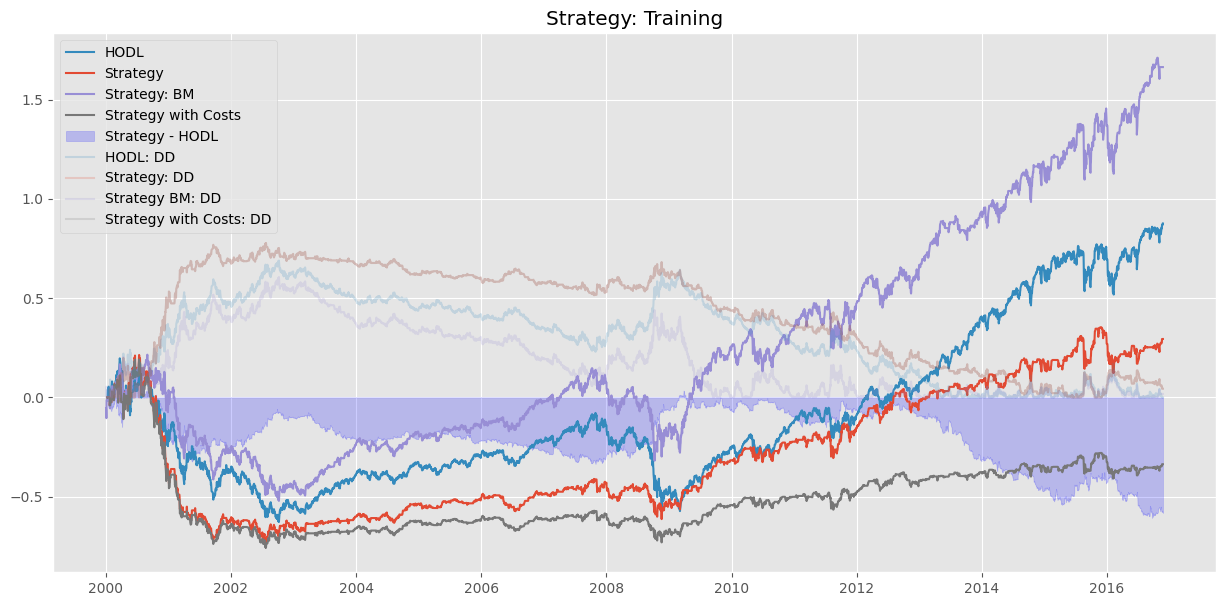

strat_pos.shape = (4246,)
strat_ret.shape = (4246,)


,strategy,strategy(bm),hodl
Asset,Undefined,Undefined,Undefined
Start,2000-01-11,2000-01-03,2000-01-03
End,2016-11-23,2016-11-23,2016-11-23
Mean Return,0.02499%,0.03809%,0.02543%
Total Return,29.40%,166.32%,87.56%
Median Return,0.00833%,0.07883%,0.08364%
1st Quartile,-0.65872%,-0.61161%,-0.60662%
3rd Quartile,0.73838%,0.70241%,0.69763%
Std Dev Return,1.78319%,1.46894%,1.45886%
CAGR,0.912 bps,2.735 bps,1.479 bps


In [120]:
desc_train, alloc_train = run(X_df=X_train_df, y_df=y_train_df, is_train=True, sub_cost=INCLUDE_COST)
desc_train

C:\Users\tomw1\AppData\Local\Temp\ipykernel_15800\2399179029.py:38: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  benchmark_alloc = X_df.iloc[:, :-1].groupby(level=2, axis=1).sum()


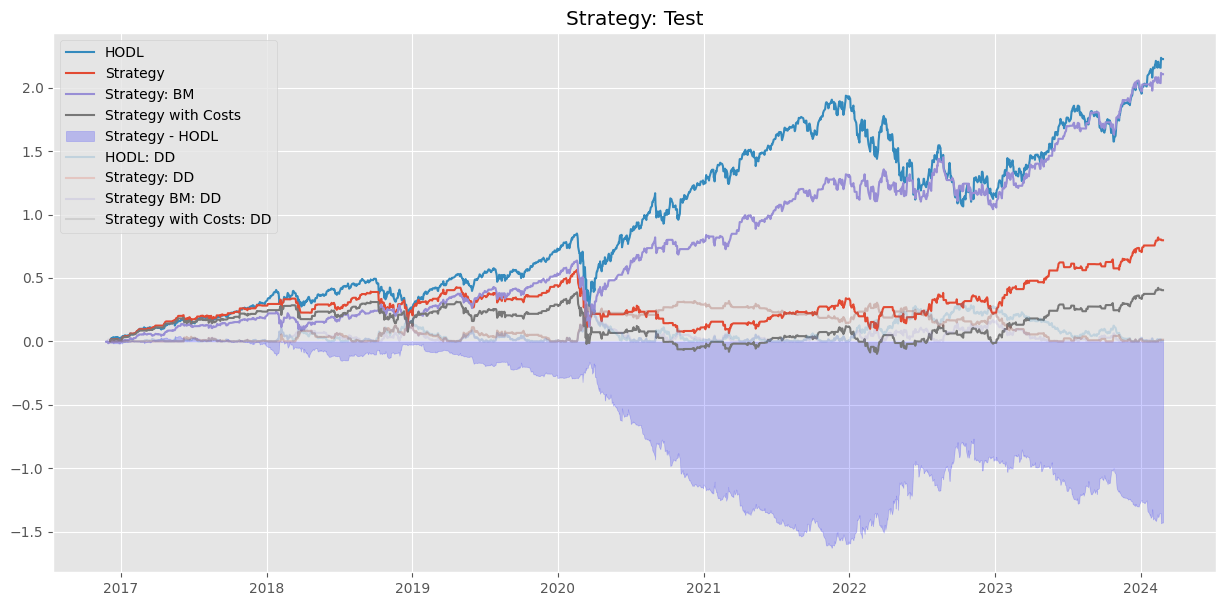

strat_pos.shape = (1817,)
strat_ret.shape = (1817,)


,strategy,strategy(bm),hodl
Asset,Undefined,Undefined,Undefined
Start,2016-12-05,2016-11-25,2016-11-25
End,2024-02-26,2024-02-26,2024-02-26
Mean Return,0.06513%,0.08535%,0.07299%
Total Return,79.70%,210.64%,222.56%
Median Return,0.05297%,0.10947%,0.10041%
1st Quartile,-0.36935%,-0.40890%,-0.43747%
3rd Quartile,0.70902%,0.72116%,0.71046%
Std Dev Return,1.45513%,1.29163%,1.30217%
CAGR,5.448 bps,7.698 bps,6.426 bps


In [121]:
desc_test, alloc_test = run(X_df=X_test_df, y_df=y_test_df, is_train=False, sub_cost=INCLUDE_COST)
desc_test

strat_type = 'overnight_trading', strat_name = 'short_term_reversal', asset = 'QQQ'
strat_type = 'overnight_trading', strat_name = 'short_term_reversal', asset = 'QQQ'


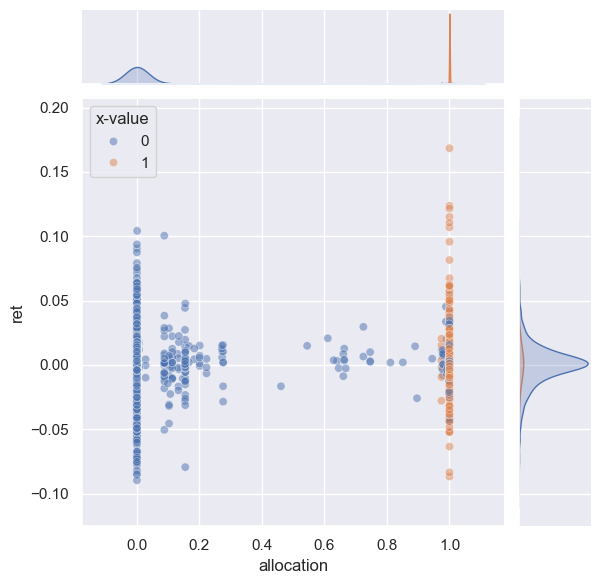

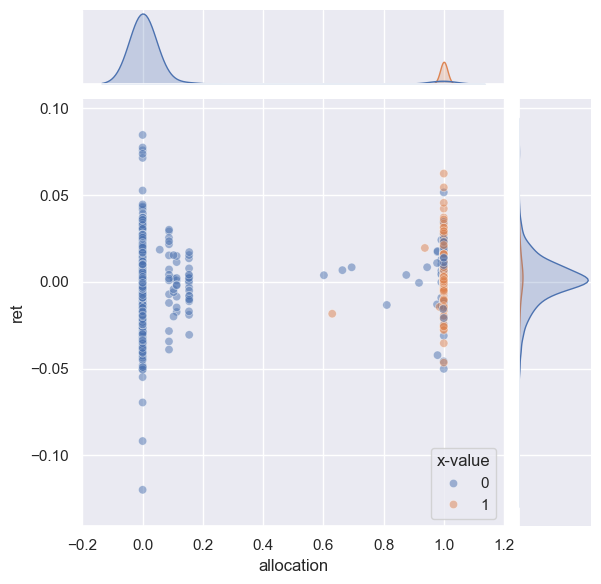

In [266]:
import seaborn as sns

def hist_plot(strategy_id: int, on_train: bool = True) -> None:

    strat_type, strat_name, asset = orig_X_total.columns[strategy]
    print(f"{strat_type = !r}, {strat_name = !r}, {asset = !r}")

    if on_train: 
        df = pd.concat([
                alloc_train[asset].to_frame(name="allocation"), 
                y_train_df[asset].to_frame(name="ret"), 
                X_train_df.iloc[:, strategy].to_frame("x-value"),
            ], axis=1)
    else:
        df = pd.concat([
                alloc_test[asset].to_frame(name="allocation"), 
                y_test_df[asset].to_frame(name="ret"), 
                X_test_df.iloc[:, strategy].to_frame("x-value"),
            ], axis=1)

    fig = sns.jointplot(
        data=df,
        x="allocation", y="ret", hue="x-value",
        alpha=0.5,
    )

    return

hist_plot(strategy_id=3)
hist_plot(strategy_id=3, on_train=False)

In [ ]:
x = asset
y = allocation
color = strategy

In [269]:
y = alloc_train.reset_index(names="Date").melt(id_vars="Date", var_name="asset", value_name="allocation").set_index(["Date", "asset"])
size = y_train_df.reset_index(names="Date").melt(id_vars="Date", var_name="asset", value_name="ret").set_index(["Date", "asset"])
color = (
    X_train_df.iloc[:, :-4]
    .reset_index()
    .melt(id_vars=[('Date', '', '')])
    .rename(columns={"variable_0": "strat_type", "variable_1": "strat_name", "variable_2": "asset", "value": "x-value", ("Date", "", ""): "Date"})
    .set_index(["Date", "asset"])
)


In [280]:
size["bucket"] = (size["ret"] < -0.02).astype(int) + (size["ret"] < -0.01).astype(int) + (size["ret"] < 0.0).astype(int) + (size["ret"] < 0.01).astype(int) + (size["ret"] < 0.02).astype(int)
size["bucket"] = size["bucket"].replace({0: ">=0.02", 1: ">=0.01,<0.02", 2: ">=0.00,<0.01", 3: ">=-0.01,<0.00", 4: ">=-0.02,<-0.01", 5: "<-0.02"})
size

,,ret,bucket
Date,asset,,
2000-01-03,SPY,-0.039106,<-0.02
2000-01-04,SPY,0.001789,">=0.00,<0.01"
2000-01-05,SPY,-0.016071,">=-0.02,<-0.01"
2000-01-06,SPY,0.058076,>=0.02
2000-01-07,SPY,0.003430,">=0.00,<0.01"
...,...,...,...
2016-11-16,CASH,0.000000,">=0.00,<0.01"
2016-11-17,CASH,0.000000,">=0.00,<0.01"
2016-11-18,CASH,0.000000,">=0.00,<0.01"


In [281]:
df = pd.merge(pd.merge(y, size, left_index=True, right_index=True, how="inner"), color, left_index=True, right_index=True, how="inner").reset_index()

In [282]:
flt = df["Date"].isin(df.loc[(df["strat_name"] == "september_bear") & (df["x-value"] == 1), "Date"])
# df_ = df.loc[(df["asset"] == "QQQ"
df_ = df.loc[flt & (df["asset"] == "QQQ")]
df_

,Date,asset,allocation,ret,bucket,strat_type,strat_name,x-value
30825,2000-09-15,QQQ,0.0,-0.015743,">=-0.02,<-0.01",event_trading,super_bowl,0
30826,2000-09-15,QQQ,0.0,-0.015743,">=-0.02,<-0.01",overnight_trading,short_term_reversal,0
30827,2000-09-15,QQQ,0.0,-0.015743,">=-0.02,<-0.01",seasonal_trading,buy_when_yields_are_low,0
30828,2000-09-15,QQQ,0.0,-0.015743,">=-0.02,<-0.01",seasonal_trading,pay_day_strategy,0
30829,2000-09-15,QQQ,0.0,-0.015743,">=-0.02,<-0.01",seasonal_trading,santa_claus_strategy,0
...,...,...,...,...,...,...,...,...
55000,2016-09-22,QQQ,0.0,-0.006382,">=-0.01,<0.00",overnight_trading,short_term_reversal,0
55001,2016-09-22,QQQ,0.0,-0.006382,">=-0.01,<0.00",seasonal_trading,buy_when_yields_are_low,0
55002,2016-09-22,QQQ,0.0,-0.006382,">=-0.01,<0.00",seasonal_trading,pay_day_strategy,0
55003,2016-09-22,QQQ,0.0,-0.006382,">=-0.01,<0.00",seasonal_trading,santa_claus_strategy,0


C:\Users\tomw1\AppData\Local\pypoetry\Cache\virtualenvs\quantified-strategies-wFBlb7GR-py3.11\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 55.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\tomw1\AppData\Local\pypoetry\Cache\virtualenvs\quantified-strategies-wFBlb7GR-py3.11\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 57.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\tomw1\AppData\Local\pypoetry\Cache\virtualenvs\quantified-strategies-wFBlb7GR-py3.11\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 52.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


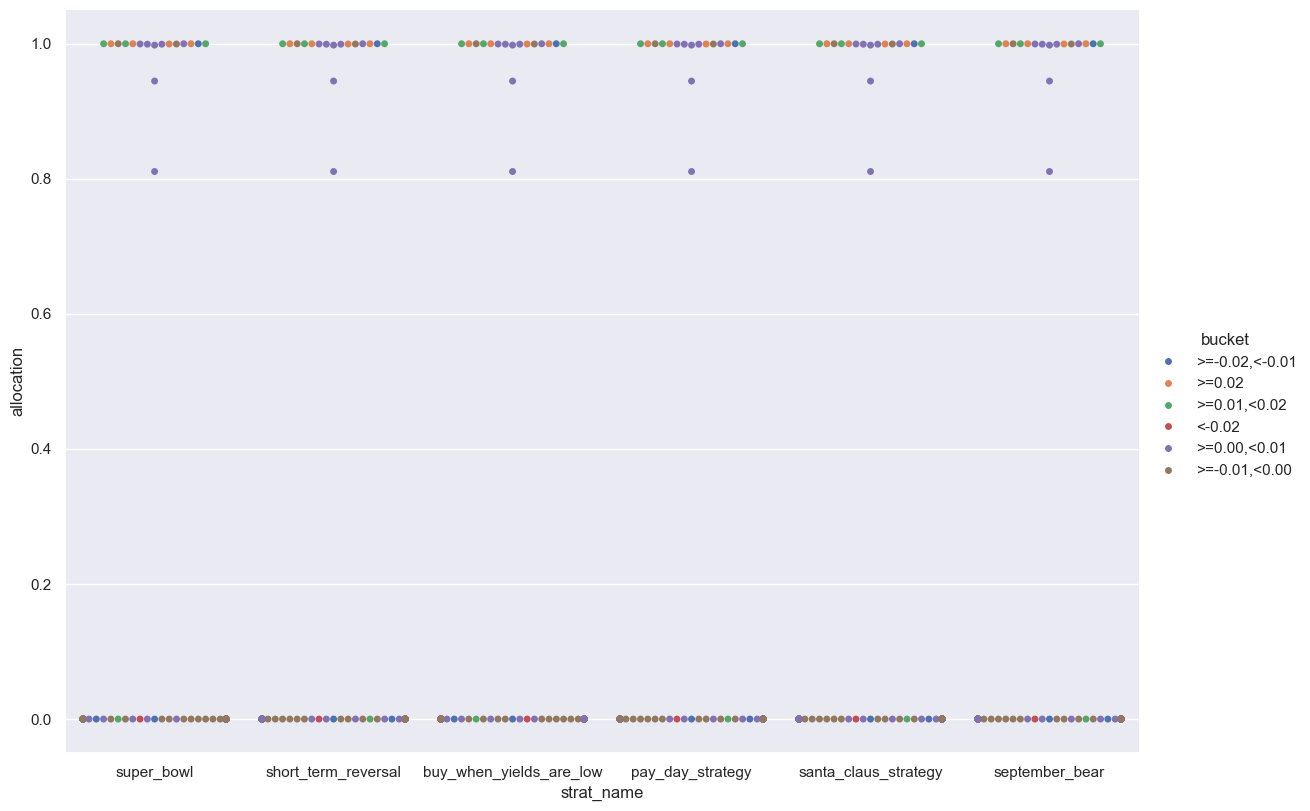

In [285]:
sns.catplot(data=df_, kind="swarm", x="strat_name", y="allocation", hue="bucket", height=8.27, aspect=11.7/8.27)

In [187]:
df_.round(2).groupby(["strat_name", "x-value"])["allocation"].value_counts().sort_index(level=[0, 1, 2])

strat_name               x-value  allocation
buy_when_yields_are_low  0        0.00          33
                                  0.81           1
                                  0.94           1
                                  1.00           8
                         1        0.00          35
                                  1.00           7
pay_day_strategy         0        0.00          50
                                  0.81           1
                                  1.00           8
                         1        0.00          18
                                  0.94           1
                                  1.00           7
santa_claus_strategy     0        0.00          68
                                  0.81           1
                                  0.94           1
                                  1.00          15
september_bear           1        0.00          68
                                  0.81           1
                                  0.9

In [179]:
df_.round(2)

,Date,asset,allocation,ret,strat_type,strat_name,x-value
30825,2000-09-15,QQQ,0.0,-0.02,event_trading,super_bowl,0
30826,2000-09-15,QQQ,0.0,-0.02,overnight_trading,short_term_reversal,0
30827,2000-09-15,QQQ,0.0,-0.02,seasonal_trading,buy_when_yields_are_low,0
30828,2000-09-15,QQQ,0.0,-0.02,seasonal_trading,pay_day_strategy,0
30829,2000-09-15,QQQ,0.0,-0.02,seasonal_trading,santa_claus_strategy,0
...,...,...,...,...,...,...,...
55000,2016-09-22,QQQ,0.0,-0.01,overnight_trading,short_term_reversal,0
55001,2016-09-22,QQQ,0.0,-0.01,seasonal_trading,buy_when_yields_are_low,0
55002,2016-09-22,QQQ,0.0,-0.01,seasonal_trading,pay_day_strategy,0
55003,2016-09-22,QQQ,0.0,-0.01,seasonal_trading,santa_claus_strategy,0


In [204]:
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


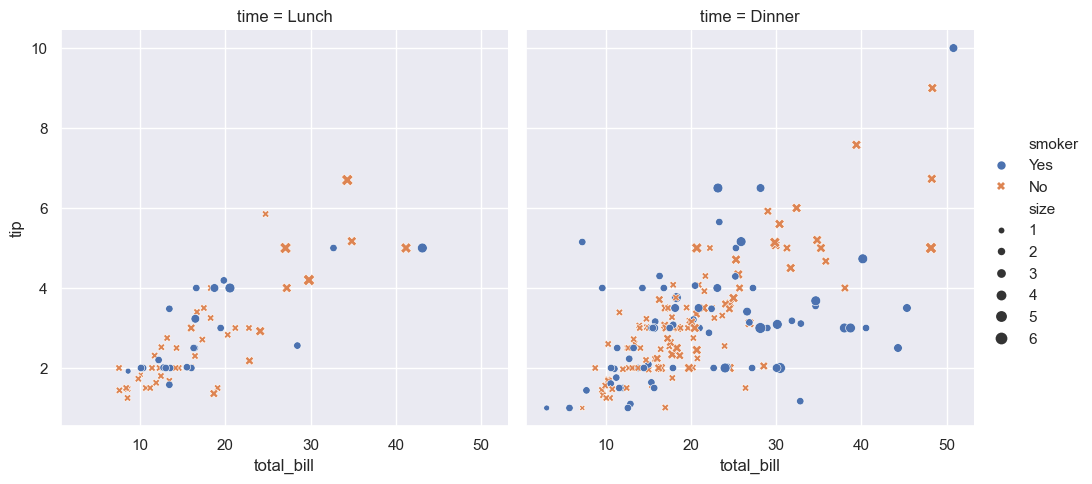

In [205]:
sns.relplot(data=tips, x="total_bill", y="tip", col="time", hue="smoker", style="smoker", size="size")